# CNN with SVD

## Importing the libraries and dependencies and drive
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib or seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import random, math, os, pickle, random, librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from itertools import combinations
%matplotlib inline

EPOCHS = 200
BATCH_SIZE = 128
IMG_SIZE = (28,28)
SEED = 100
CLASSES = 10
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

## Loading Data
The following block of code loads MNIST data in two formats.
- First is through the dataset module from keras which loads data in numpy arrays.
- Second is the TFDS - Tensorflow dataset module which loads data in the format of tenorflow_dataset whic makes it fast o process and load data onto and away from the memory(GPU/CPU)

I experimented with both the above techniques but the second one was very fast and thats what i am sticking with.
As it loads the next batch of data onto GPU memory while the current batch is being operated on - this is done with the prefetching functionality of the tensorflow_dataset module.

In [11]:
# df_train, df_test = tf.keras.datasets.mnist.load_data()

(df_train, df_test), df_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files = False,
    with_info = True,
    as_supervised = True
)

In [6]:
df_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

## Labels for the data & Look at the data

In [9]:
{df_info.features['label'].str2int(x):x for x in df_info.features['label'].names}

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

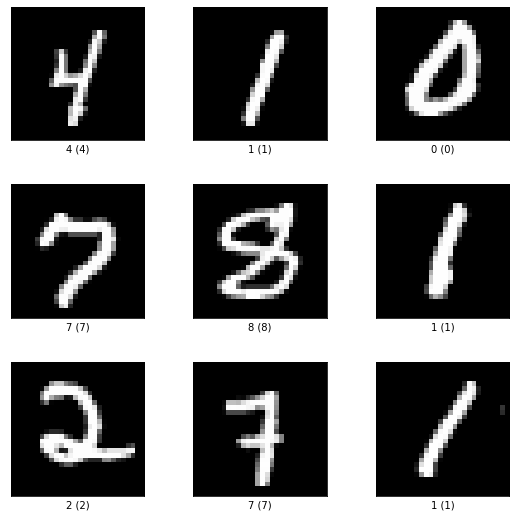

In [12]:
fig = tfds.show_examples(df_train, df_info)

Processing the dataset and turning each set into a trainable and testable sets.

In [13]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, depth=10)

df_train = df_train.map(normalize, 
                        num_parallel_calls = tf.data.experimental.AUTOTUNE)
df_train = df_train.cache()
df_train = df_train.shuffle(df_info.splits['train'].num_examples)
df_train = df_train.batch(BATCH_SIZE)
df_train = df_train.prefetch(tf.data.experimental.AUTOTUNE)

df_test = df_test.map(normalize, num_parallel_calls = tf.data.experimental.AUTOTUNE)
df_test = df_test.cache()
df_test = df_test.batch(BATCH_SIZE)
df_test = df_test.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% validation accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# checkpoint = keras.callbacks.ModelCheckpoint('', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

## Baseline with external SVD

### Model architecture & helper methods
There are three helper methods :-
- seed_everthing - sets the seed for numpy, tensorflow and random modules so that when we try and replicate a result we can do so if the seeds are same.
- clear_tf - clears the backend of the tensorflow module.
- Model - this method defines a common method which will used commonly accross all the question to define a Deep Learning model.

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.compat.v1.random.set_random_seed(seed)
    tf.compat.v2.random.set_seed(seed)

def clear_tf():
    tf.keras.backend.clear_session()

def Model(img_shape = IMG_SIZE, 
          output_units = 10,
          activation_fn = tf.keras.layers.LeakyReLU(),
          initializer = 'glorot_uniform',
          num_layers = 5,
          units_per_layer = [1024]*5,
          include_normalization = True,
          include_dropout = True,
          dropout_rate = [0.2]*5):
    
    inp = tf.keras.Input(shape = img_shape)
    layer = tf.keras.layers.Flatten()(inp)
    layer = tf.keras.layers.Dense(units_per_layer[0], 
                                  activation = activation_fn, 
                                  kernel_initializer=initializer,
                                  name = 'Dense_layer_1')(layer)
    if include_normalization:
        layer = tf.keras.layers.BatchNormalization()(layer)
    if include_dropout:
        layer = tf.keras.layers.Dropout(dropout_rate[0])(layer)
    for idx in range(1, num_layers):
        layer = tf.keras.layers.Dense(units_per_layer[idx],
                                      activation = activation_fn,
                                      kernel_initializer = initializer,
                                      name = 'Dense_layer_'+str(idx+1))(layer)
        if include_normalization:
            layer = tf.keras.layers.BatchNormalization()(layer)
        if include_dropout:
            layer = tf.keras.layers.Dropout(dropout_rate[idx])(layer)

    out = tf.keras.layers.Dense(output_units, 
                                activation = 'softmax', 
                                kernel_initializer = initializer,
                                name = 'Output')(layer)

    model = tf.keras.models.Model(inputs = inp, outputs = out)
    return model

seed_everything(SEED)
clear_tf()

### Model Summary & training

In [4]:
Model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Dense_layer_1 (Dense)       (None, 1024)              803840    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 Dense_layer_2 (Dense)       (None, 1024)              1049600   
                                                             

In [8]:
model = Model()
model.compile(metrics = ['accuracy'],
              loss = 'categorical_crossentropy',
              optimizer = 'adam')
model.fit(df_train, 
          validation_data = df_test,
          epochs = EPOCHS,
          callbacks = [CustomCallback()])

Epoch 1/200
469/469 [==============================] - 12s 9ms/step - loss: 0.2938 - accuracy: 0.9164 - val_loss: 0.1682 - val_accuracy: 0.9506
Epoch 2/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1513 - accuracy: 0.9546 - val_loss: 0.1479 - val_accuracy: 0.9592
Epoch 3/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1246 - accuracy: 0.9604 - val_loss: 0.1148 - val_accuracy: 0.9662
Epoch 4/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1047 - accuracy: 0.9678 - val_loss: 0.1055 - val_accuracy: 0.9687
Epoch 5/200
469/469 [==============================] - 3s 6ms/step - loss: 0.0937 - accuracy: 0.9711 - val_loss: 0.0878 - val_accuracy: 0.9753
Epoch 6/200
469/469 [==============================] - 3s 6ms/step - loss: 0.0865 - accuracy: 0.9724 - val_loss: 0.0960 - val_accuracy: 0.9719
Epoch 7/200
469/469 [==============================] - 3s 6ms/step - loss: 0.0787 - accuracy: 0.9751 - val_loss: 0.1090 - val_accuracy: 0.969

### SVD 

In [9]:
weights = {}
bias = {}
for layer in model.layers:
    if 'Dense' in layer.name:
        weights[layer.name] = layer.get_weights()[0]
        bias[layer.name] = layer.get_weights()[1]

79/79 [==============================] - 0s 3ms/step - loss: 0.0741 - accuracy: 0.9817


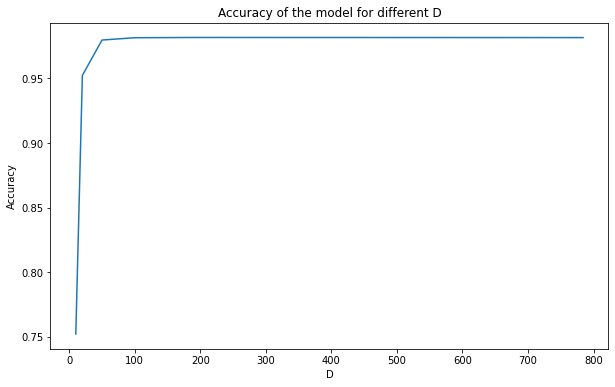

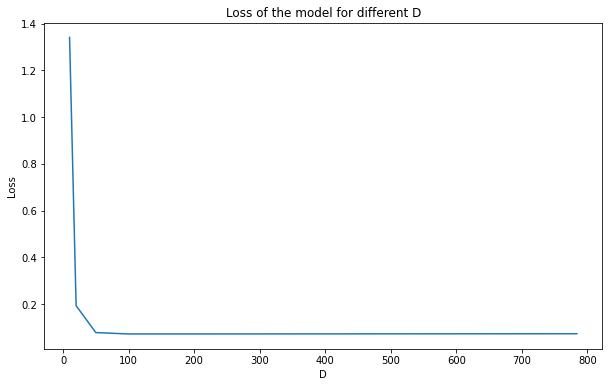

In [21]:
def get_new_weights(D, model, weights, bias):
    for key in weights:
        s, u, v = tf.linalg.svd(weights[key])
        if D == -1:
            D == s.shape[0]
        new_weight = tf.matmul(u[:,:D], tf.matmul(tf.linalg.diag(s)[:D,:D], tf.transpose(v[:,:D])))
        # new_weight = tf.matmul(tf.matmul(u[:,:D], tf.linalg.diag(s)[:D,:D]), tf.transpose(v[:,:D]))
        model.get_layer(key).set_weights([new_weight, bias[key]])
    return model.evaluate(df_test)

d_vals = [10, 20, 50, 100, 200, -1]
accuracies = []
losses = []
for d in d_vals:
    loss, acc = get_new_weights(d, model, weights, bias)
    losses.append(loss)
    accuracies.append(acc)

d_vals[-1] = 784
plt.figure(figsize = (10,6))
plt.plot(d_vals, accuracies)
plt.title("Accuracy of the model for different D")
plt.xlabel('D')
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize = (10,6))
plt.plot(d_vals, losses)
plt.title("Loss of the model for different D")
plt.xlabel('D')
plt.ylabel("Loss")
plt.show()

## Model with layer wise SVD weights

### Model Architecture & Summary

In [42]:
D = 20

inp = tf.keras.Input(shape = IMG_SIZE)
flat = tf.keras.layers.Flatten()(inp)
u = tf.keras.layers.Dense(D, 
                          name='u_Dense_1',
                          activation = tf.keras.layers.LeakyReLU(),
                          kernel_initializer = 'glorot_uniform')(flat)
v = tf.keras.layers.Dense(1024, 
                          name='v_Dense_1',
                          activation = tf.keras.layers.LeakyReLU(),
                          kernel_initializer = 'glorot_uniform')(u)
layer = tf.keras.layers.BatchNormalization()(v)
layer = tf.keras.layers.Dropout(0.2)(layer)

for i in range(2, 6):
    u = tf.keras.layers.Dense(D, 
                          name=f'u_Dense_{i}',
                          activation = tf.keras.layers.LeakyReLU(),
                          kernel_initializer = 'glorot_uniform')(layer)
    v = tf.keras.layers.Dense(1024, 
                            name=f'v_Dense_{i}',
                            activation = tf.keras.layers.LeakyReLU(),
                            kernel_initializer = 'glorot_uniform')(u)
    layer = tf.keras.layers.BatchNormalization()(v)
    layer = tf.keras.layers.Dropout(0.2)(layer)
out = tf.keras.layers.Dense(10,
                            activation = 'softmax', 
                            kernel_initializer = 'glorot_uniform',
                            name = 'Output')(layer)

model = tf.keras.models.Model(inputs = inp, outputs = out)
model.compile(metrics=['accuracy'],
              loss = 'categorical_crossentropy',
              optimizer = 'adam')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 u_Dense_1 (Dense)           (None, 20)                15700     
                                                                 
 v_Dense_1 (Dense)           (None, 1024)              21504     
                                                                 
 batch_normalization_15 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                           

### Weights assignment from D = 20 SVD

In [43]:
# Get weights
s1, u1, v1 = tf.linalg.svd(weights['Dense_layer_1'])
V1 = tf.matmul(tf.linalg.diag(s1)[:D,:D], tf.transpose(v1[:,:D]))

s2, u2, v2 = tf.linalg.svd(weights['Dense_layer_2'])
V2 = tf.matmul(tf.linalg.diag(s2)[:D,:D], tf.transpose(v2[:,:D]))

s3, u3, v3 = tf.linalg.svd(weights['Dense_layer_3'])
V3 = tf.matmul(tf.linalg.diag(s3)[:D,:D], tf.transpose(v3[:,:D]))

s4, u4, v4 = tf.linalg.svd(weights['Dense_layer_4'])
V4 = tf.matmul(tf.linalg.diag(s4)[:D,:D], tf.transpose(v4[:,:D]))

s5, u5, v5 = tf.linalg.svd(weights['Dense_layer_5'])
V5 = tf.matmul(tf.linalg.diag(s5)[:D,:D], tf.transpose(v5[:,:D]))

# Load weights from D = 20 SVD
model.get_layer("u_Dense_1").set_weights([u1[:,:D], bias['Dense_layer_1'][:D]])
model.get_layer("v_Dense_1").set_weights([V1, bias['Dense_layer_1']])

model.get_layer("u_Dense_2").set_weights([u2[:,:D], bias['Dense_layer_2'][:D]])
model.get_layer("v_Dense_2").set_weights([V2, bias['Dense_layer_2']])

model.get_layer("u_Dense_3").set_weights([u3[:,:D], bias['Dense_layer_3'][:D]])
model.get_layer("v_Dense_3").set_weights([V3, bias['Dense_layer_3']])

model.get_layer("u_Dense_4").set_weights([u4[:,:D], bias['Dense_layer_4'][:D]])
model.get_layer("v_Dense_4").set_weights([V4, bias['Dense_layer_4']])

model.get_layer("u_Dense_5").set_weights([u5[:,:D], bias['Dense_layer_5'][:D]])
model.get_layer("v_Dense_5").set_weights([V5, bias['Dense_layer_5']])

### Training

In [44]:
model.fit(df_train, validation_data=df_test, epochs=20)

loss, acc = model.evaluate(df_test)

print("Loss {}, Accuracy {}".format(loss, acc))

Epoch 1/20
469/469 [==============================] - 5s 7ms/step - loss: 0.2425 - accuracy: 0.9262 - val_loss: 0.1518 - val_accuracy: 0.9557
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1476 - accuracy: 0.9555 - val_loss: 0.1268 - val_accuracy: 0.9619
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1268 - accuracy: 0.9617 - val_loss: 0.1341 - val_accuracy: 0.9632
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1136 - accuracy: 0.9651 - val_loss: 0.1244 - val_accuracy: 0.9651
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1030 - accuracy: 0.9687 - val_loss: 0.1318 - val_accuracy: 0.9615
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0990 - accuracy: 0.9700 - val_loss: 0.1184 - val_accuracy: 0.9661
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0933 - accuracy: 0.9712 - val_loss: 0.1206 - val_accuracy: 0.9665
Epoch 

Test time classification accuracy and loss are found out using the evaluate function of the model and displayed as the last line of the previous cell.

## SVD at each epoch during training

### Custom Layer
Here a custom layer is defined which takes tha input from the previous layer and does SVD on the weights and then perform the next step using the 20 units from the SVD'ed weights.

In [50]:
class SimpleDense(tf.keras.layers.Layer):
    def __init__(self, 
                 units=32, 
                 activation='relu', 
                 kernel_initializer = 'glorot_normal', 
                 bias_initializer = 'glorot_normal', 
                 name = ""):
        super(SimpleDense, self).__init__(name = name)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        # initialize the weights
        if self.kernel_initializer != None:
            w_init = self.kernel_initializer()
        else:
            w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name="kernel",   
                             initial_value=w_init(shape=(input_shape[-1], self.units),dtype='float32'),trainable=True)

        # initialize the biases
        if self.bias_initializer != None:
            b_init = self.bias_initializer()
        else:
            b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
                             initial_value=b_init(shape=(self.units,), dtype='float32'),trainable=True)

    def call(self, inputs):
        s, u, v = tf.linalg.svd(self.w)
        w1 = tf.matmul(tf.matmul(u[:,:20], tf.linalg.diag(s)[:20,:20]), tf.transpose(v[:,:20]))
        return self.activation(tf.matmul(inputs, w1) + self.b)


### Model architecture & Summary

In [54]:
inp = tf.keras.Input(shape = IMG_SIZE)
flat = tf.keras.layers.Flatten()(inp)
layer = SimpleDense(1024, 
                    name = "Custom_layer_1",
                    activation = tf.keras.layers.LeakyReLU())(flat)
layer = tf.keras.layers.BatchNormalization()(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)

for i in range(2, 6):
    layer = SimpleDense(1024, 
                    name = f"Custom_layer_{i}",
                    activation = tf.keras.layers.LeakyReLU())(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
out = tf.keras.layers.Dense(10, 
                                activation = 'softmax', 
                                kernel_initializer = 'glorot_uniform',
                                name = 'Output')(layer)

model_ques_3 = tf.keras.models.Model(inputs = inp, outputs = out)
model_ques_3.compile(metrics=['accuracy'],
              loss = 'categorical_crossentropy',
              optimizer = 'adam')
model_ques_3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 Custom_layer_1 (SimpleDense  (None, 1024)             803840    
 )                                                               
                                                                 
 batch_normalization_22 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_22 (Dropout)        (None, 1024)              0         
                                                                 
 Custom_layer_2 (SimpleDense  (None, 1024)             1049

### Setting Weights from the baseline model

In [55]:
model_ques_3.get_layer("Custom_layer_1").set_weights([weights['Dense_layer_1'], bias['Dense_layer_1']])
model_ques_3.get_layer("Custom_layer_2").set_weights([weights['Dense_layer_2'], bias['Dense_layer_2']])
model_ques_3.get_layer("Custom_layer_3").set_weights([weights['Dense_layer_3'], bias['Dense_layer_3']])
model_ques_3.get_layer("Custom_layer_4").set_weights([weights['Dense_layer_4'], bias['Dense_layer_4']])
model_ques_3.get_layer("Custom_layer_5").set_weights([weights['Dense_layer_5'], bias['Dense_layer_5']])

### Training

In [56]:
model_ques_3.fit(df_train, validation_data=df_test, epochs=10)

loss, acc = model_ques_3.evaluate(df_test)

print("Loss {}, Accuracy {}".format(loss, acc))

Epoch 1/10
469/469 [==============================] - 801s 2s/step - loss: 0.1260 - accuracy: 0.9611 - val_loss: 0.1154 - val_accuracy: 0.9652
Epoch 2/10
469/469 [==============================] - 800s 2s/step - loss: 0.0846 - accuracy: 0.9733 - val_loss: 0.1024 - val_accuracy: 0.9731
Epoch 3/10
469/469 [==============================] - 801s 2s/step - loss: 0.0774 - accuracy: 0.9753 - val_loss: 0.0840 - val_accuracy: 0.9747
Epoch 4/10
469/469 [==============================] - 802s 2s/step - loss: 0.0688 - accuracy: 0.9776 - val_loss: 0.0888 - val_accuracy: 0.9752
Epoch 5/10
469/469 [==============================] - 801s 2s/step - loss: 0.0670 - accuracy: 0.9791 - val_loss: 0.0865 - val_accuracy: 0.9772
Epoch 6/10
469/469 [==============================] - 803s 2s/step - loss: 0.0640 - accuracy: 0.9795 - val_loss: 0.0927 - val_accuracy: 0.9723
Epoch 7/10
469/469 [==============================] - 803s 2s/step - loss: 0.0529 - accuracy: 0.9834 - val_loss: 0.0824 - val_accuracy: 0.9779